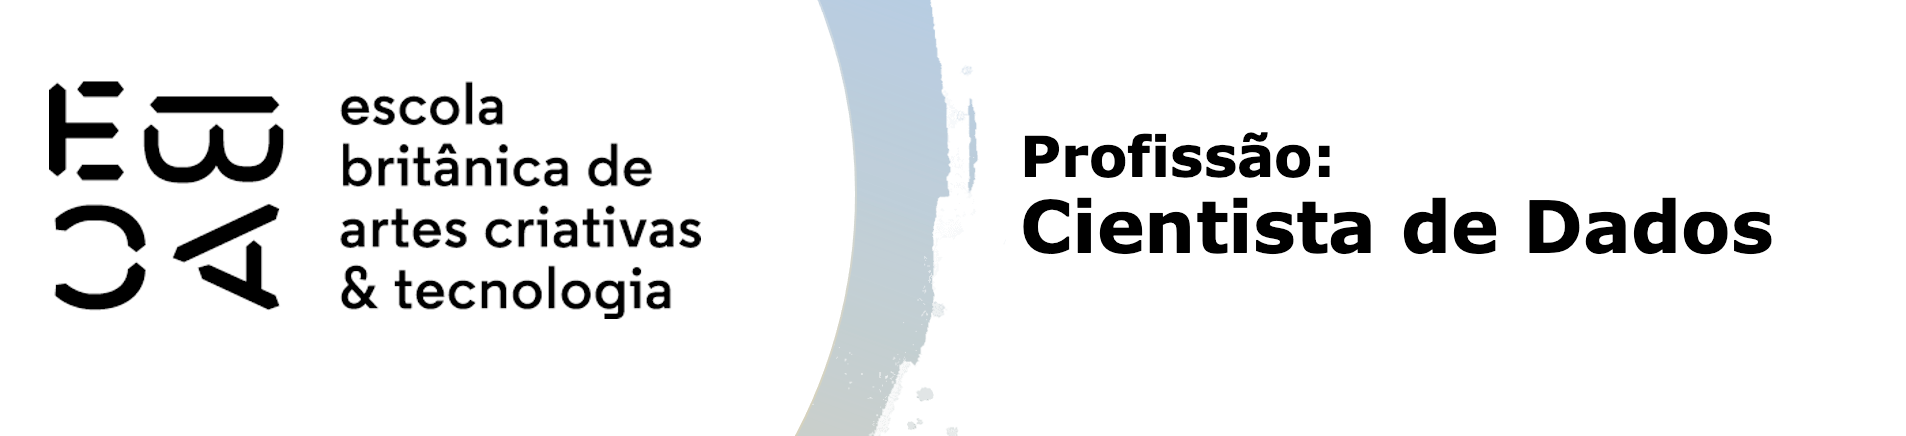

# Tarefa

Neste exercício vamos usar a base [online shoppers purchase intention](https://archive.ics.uci.edu/ml/datasets/Online+Shoppers+Purchasing+Intention+Dataset) de Sakar, C.O., Polat, S.O., Katircioglu, M. et al. Neural Comput & Applic (2018). [Web Link](https://doi.org/10.1007/s00521-018-3523-0).

A base trata de registros de 12.330 sessões de acesso a páginas, cada sessão sendo de um único usuário em um período de 12 meses, para posteriormente estudarmos a relação entre o design da página e o perfil do cliente - "Será que clientes com comportamento de navegação diferentes possuem propensão a compra diferente?" 

Nosso objetivo é tentar agrupar os clientes conforme seu comportamento de navegação entre páginas administrativas, informativas e de produtos. 

As variáveis estão descritas abaixo (em tradução livre do link indicado).

Por este motivo, o escopo desta análise estará fechado nas primeiras seis variáveis da tabela, referentes a quantidade e tempo de acesso por tipo de página, atributos que falam mais do comportamento de navegação do cliente que de características da página o da época do ano.

|Variavel                |Descrição          | 
|------------------------|:-------------------| 
|Administrative          | Quantidade de acessos em páginas administrativas| 
|Administrative_Duration | Tempo de acesso em páginas administrativas | 
|Informational           | Quantidade de acessos em páginas informativas  | 
|Informational_Duration  | Tempo de acesso em páginas informativas  | 
|ProductRelated          | Quantidade de acessos em páginas de produtos | 
|ProductRelated_Duration | Tempo de acesso em páginas de produtos | 
|BounceRates             | *Percentual de visitantes que entram no site e saem sem acionar outros *requests* durante a sessão  | 
|ExitRates               | * Soma de vezes que a página é visualizada por último em uma sessão dividido pelo total de visualizações | 
|PageValues              | * Representa o valor médio de uma página da Web que um usuário visitou antes de concluir uma transação de comércio eletrônico | 
|SpecialDay              | Indica a proximidade a uma data festiva (dia das mães etc) | 
|Month                   | Mês  | 
|OperatingSystems        | Sistema operacional do visitante | 
|Browser                 | Browser do visitante | 
|Region                  | Região | 
|TrafficType             | Tipo de tráfego                  | 
|VisitorType             | Tipo de visitante: novo ou recorrente | 
|Weekend                 | Indica final de semana | 
|Revenue                 | Indica se houve compra ou não |

\* variávels calculadas pelo google analytics

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

from sklearn.metrics import silhouette_score
from tqdm.notebook import tqdm

In [2]:
df = pd.read_csv('online_shoppers_intention.csv')

In [3]:
df.head()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
0,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,1,1,1,1,Returning_Visitor,False,False
1,0,0.0,0,0.0,2,64.000000,0.00,0.10,0.0,0.0,Feb,2,2,1,2,Returning_Visitor,False,False
2,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,4,1,9,3,Returning_Visitor,False,False
3,0,0.0,0,0.0,2,2.666667,0.05,0.14,0.0,0.0,Feb,3,2,2,4,Returning_Visitor,False,False
4,0,0.0,0,0.0,10,627.500000,0.02,0.05,0.0,0.0,Feb,3,3,1,4,Returning_Visitor,True,False


In [4]:
df.Revenue.value_counts(dropna=False)

False    10422
True      1908
Name: Revenue, dtype: int64

## Análise descritiva

Faça uma análise descritiva das variáveis do escopo.

- Verifique a distribuição dessas variáveis
- Veja se há valores *missing* e caso haja, decida o que fazer
- Faça mais algum tratamento nas variáveis caso ache pertinente

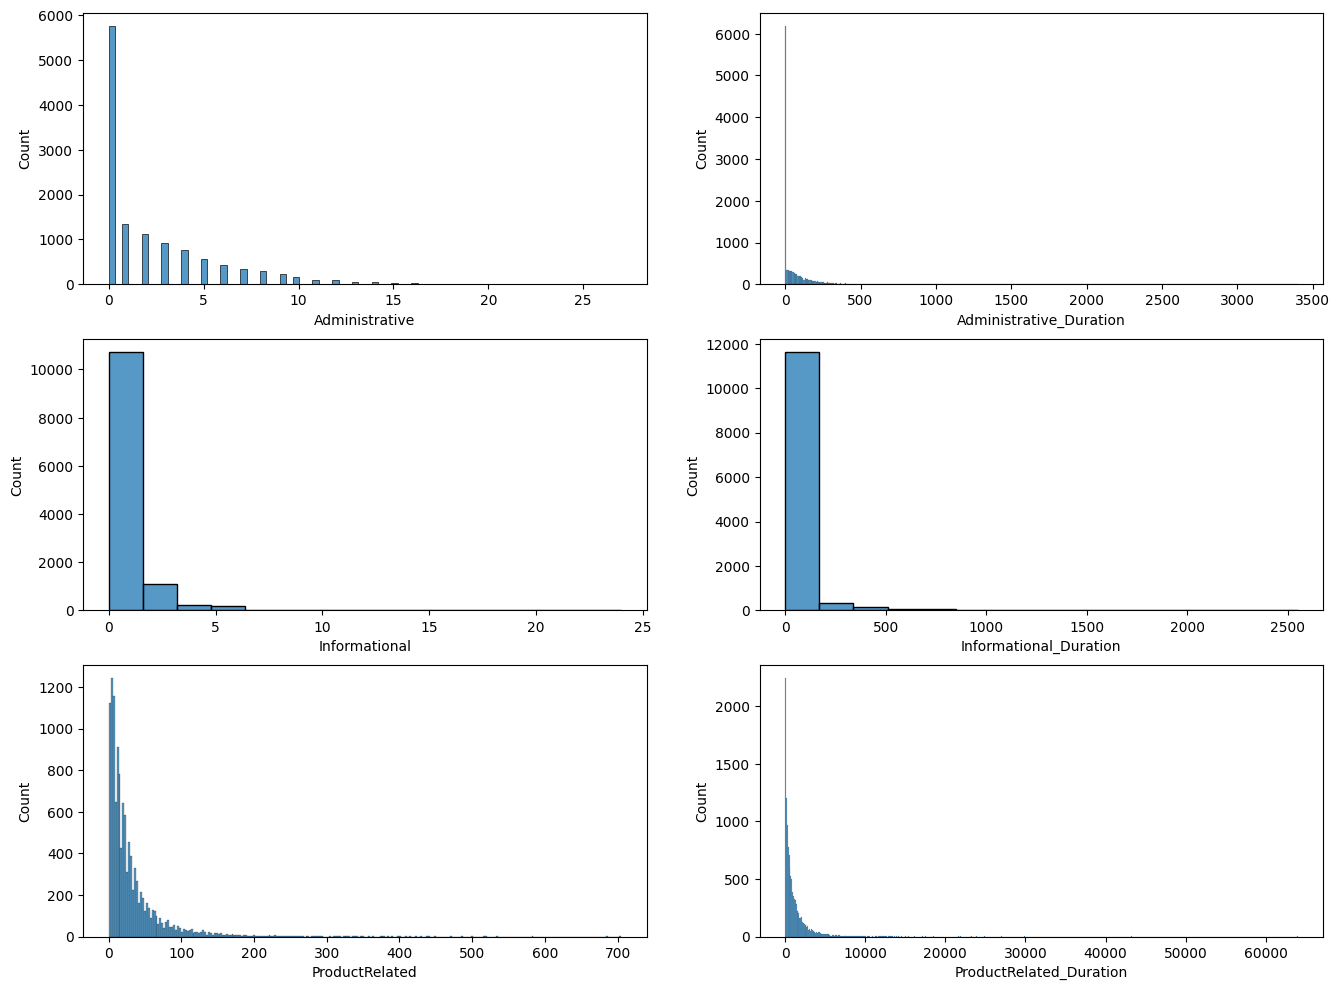

In [5]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(16, 12))
variaveis = df.columns[:6]
for i, var in enumerate(variaveis):
    sns.histplot(ax=axes[i//2][i%2], x=df[var])


In [6]:
for var in variaveis:
    print(f"# {var}")
    print(df[var].isna().value_counts())

# Administrative
False    12330
Name: Administrative, dtype: int64
# Administrative_Duration
False    12330
Name: Administrative_Duration, dtype: int64
# Informational
False    12330
Name: Informational, dtype: int64
# Informational_Duration
False    12330
Name: Informational_Duration, dtype: int64
# ProductRelated
False    12330
Name: ProductRelated, dtype: int64
# ProductRelated_Duration
False    12330
Name: ProductRelated_Duration, dtype: int64


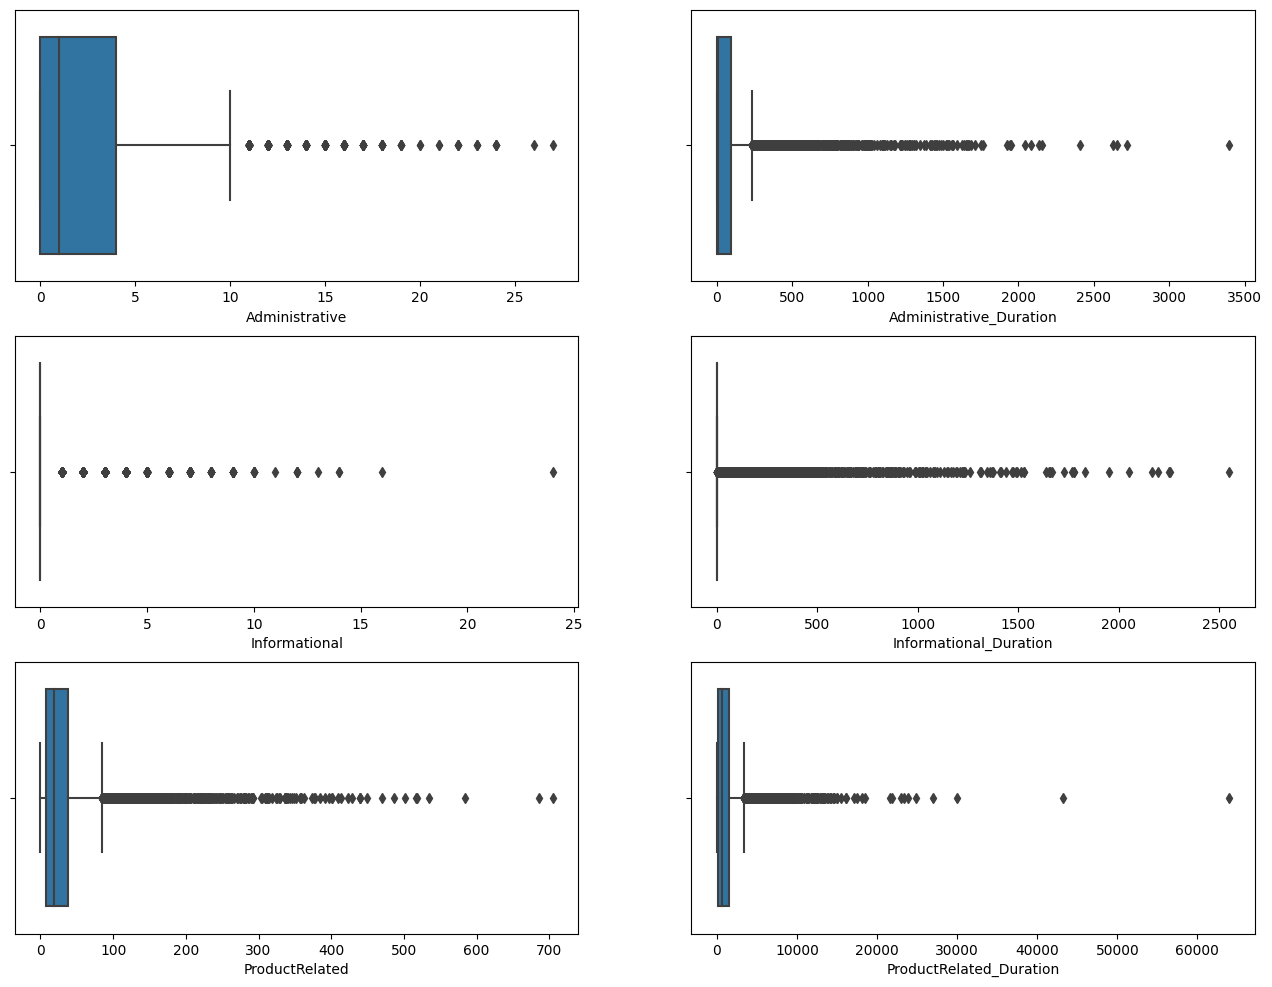

In [7]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(16, 12))
variaveis = df.columns[:6]
for i, var in enumerate(variaveis):
    sns.boxplot(ax=axes[i//2][i%2], x=df[var])

In [8]:
for var in variaveis:
    q1 = df[var].quantile(q=0.25)
    q3 = df[var].quantile(q=0.75)
    iqr = q3 - q1
    outliers_cut = q3 + (1.5 * iqr)
    print(var, outliers_cut, q3)
    print(df.query(f"{var} > @outliers_cut").shape[0])

Administrative 10.0 4.0
404
Administrative_Duration 233.14062499999997 93.25625
1172
Informational 0.0 0.0
2631
Informational_Duration 0.0 0.0
2405
ProductRelated 84.5 38.0
987
ProductRelated_Duration 3384.1867837500004 1464.1572135000001
961


## Número de grupos

Utilize as técnicas vistas em aula que te ajudem a decidir pelo número de grupos a ser utilizados.

In [9]:
X = df[variaveis]
X_train, X_test = train_test_split(X, test_size=0.3)
X_train.shape, X_test.shape

((8631, 6), (3699, 6))

In [10]:
X_pad = pd.DataFrame(StandardScaler().fit_transform(X_train), columns = X_train.columns)
X_pad

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration
0,-0.402207,-0.428536,-0.395977,-0.245084,0.704060,0.101635
1,-0.700493,-0.456789,-0.395977,-0.245084,-0.379855,-0.457597
2,-0.402207,-0.315522,-0.395977,-0.245084,-0.086294,0.543658
3,-0.700493,-0.456789,-0.395977,-0.245084,-0.244365,-0.379206
4,-0.402207,0.399293,-0.395977,-0.245084,-0.492763,-0.468344
...,...,...,...,...,...,...
8626,-0.700493,-0.456789,1.959415,3.994971,0.771805,0.440947
8627,-0.700493,-0.456789,-0.395977,-0.245084,-0.583089,-0.601312
8628,-0.700493,-0.456789,-0.395977,-0.245084,-0.492763,-0.595097
8629,-0.103921,-0.369674,4.314807,0.922625,-0.537926,-0.551940


In [11]:
SSD = []
K = range(1, 15)
for k in tqdm(K):
    km = KMeans(n_init=10, n_clusters=k)
    km = km.fit(X_pad)
    SSD.append(km.inertia_)

  0%|          | 0/14 [00:00<?, ?it/s]

In [12]:
SSD

[51786.00000000003,
 35878.88337004922,
 30467.97497812014,
 26307.390563140092,
 23603.757858803794,
 20926.18863769426,
 18631.468848796514,
 16712.4921489561,
 15469.743996105048,
 14461.79635353865,
 13511.636183027586,
 12865.771264193922,
 12257.996836566177,
 11748.030267682509]

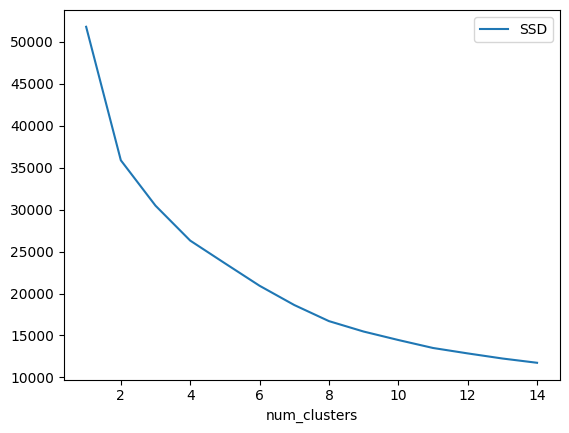

In [13]:
elbow_df = pd.DataFrame({'num_clusters': list(range(1, len(SSD)+1)), 'SSD': SSD})
elbow_df.plot(x = 'num_clusters', y = 'SSD');

In [14]:
km = KMeans(n_init=10, n_clusters=1)
km = km.fit(X_pad)
km.labels_

array([0, 0, 0, ..., 0, 0, 0])

In [15]:
silhuetas = []
K = range(2, 15)
for k in tqdm(K):
    km = KMeans(n_init=10, n_clusters=k)
    km = km.fit(X_pad)
    silhuetas.append(silhouette_score(X_pad, km.labels_))


  0%|          | 0/13 [00:00<?, ?it/s]

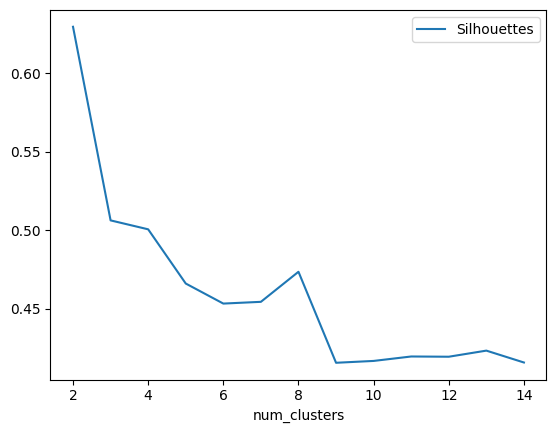

In [16]:
silhouettes_df = pd.DataFrame({'num_clusters': list(K), 'Silhouettes': silhuetas})
silhouettes_df.plot(x = 'num_clusters', y = 'Silhouettes');


In [37]:
km = KMeans(n_init=10, n_clusters=2).fit(X_pad)
model = X_pad.copy()
model['y1'] = df["Revenue"]
model['y2'] = df["BounceRates"]
model["2_grupos"] = km.labels_
model["2_grupos"] = model["2_grupos"].astype("category")
model

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,y1,y2,2_grupos
0,-0.402207,-0.428536,-0.395977,-0.245084,0.704060,0.101635,False,0.200000,0
1,-0.700493,-0.456789,-0.395977,-0.245084,-0.379855,-0.457597,False,0.000000,0
2,-0.402207,-0.315522,-0.395977,-0.245084,-0.086294,0.543658,False,0.200000,0
3,-0.700493,-0.456789,-0.395977,-0.245084,-0.244365,-0.379206,False,0.050000,0
4,-0.402207,0.399293,-0.395977,-0.245084,-0.492763,-0.468344,False,0.020000,0
...,...,...,...,...,...,...,...,...,...
8626,-0.700493,-0.456789,1.959415,3.994971,0.771805,0.440947,False,0.000000,1
8627,-0.700493,-0.456789,-0.395977,-0.245084,-0.583089,-0.601312,True,0.018182,0
8628,-0.700493,-0.456789,-0.395977,-0.245084,-0.492763,-0.595097,False,0.000000,0
8629,-0.103921,-0.369674,4.314807,0.922625,-0.537926,-0.551940,True,0.000000,1


In [38]:
km = KMeans(n_init=10, n_clusters=3).fit(X_pad)
model["3_grupos"] = km.labels_
model["3_grupos"] = model["3_grupos"].astype("category")
model

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,y1,y2,2_grupos,3_grupos
0,-0.402207,-0.428536,-0.395977,-0.245084,0.704060,0.101635,False,0.200000,0,1
1,-0.700493,-0.456789,-0.395977,-0.245084,-0.379855,-0.457597,False,0.000000,0,1
2,-0.402207,-0.315522,-0.395977,-0.245084,-0.086294,0.543658,False,0.200000,0,1
3,-0.700493,-0.456789,-0.395977,-0.245084,-0.244365,-0.379206,False,0.050000,0,1
4,-0.402207,0.399293,-0.395977,-0.245084,-0.492763,-0.468344,False,0.020000,0,1
...,...,...,...,...,...,...,...,...,...,...
8626,-0.700493,-0.456789,1.959415,3.994971,0.771805,0.440947,False,0.000000,1,0
8627,-0.700493,-0.456789,-0.395977,-0.245084,-0.583089,-0.601312,True,0.018182,0,1
8628,-0.700493,-0.456789,-0.395977,-0.245084,-0.492763,-0.595097,False,0.000000,0,1
8629,-0.103921,-0.369674,4.314807,0.922625,-0.537926,-0.551940,True,0.000000,1,1


In [39]:
km = KMeans(n_init=10, n_clusters=4).fit(X_pad)
model["4_grupos"] = km.labels_
model["4_grupos"] = model["4_grupos"].astype("category")
model.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8631 entries, 0 to 8630
Data columns (total 11 columns):
 #   Column                   Non-Null Count  Dtype   
---  ------                   --------------  -----   
 0   Administrative           8631 non-null   float64 
 1   Administrative_Duration  8631 non-null   float64 
 2   Informational            8631 non-null   float64 
 3   Informational_Duration   8631 non-null   float64 
 4   ProductRelated           8631 non-null   float64 
 5   ProductRelated_Duration  8631 non-null   float64 
 6   y1                       8631 non-null   bool    
 7   y2                       8631 non-null   float64 
 8   2_grupos                 8631 non-null   category
 9   3_grupos                 8631 non-null   category
 10  4_grupos                 8631 non-null   category
dtypes: bool(1), category(3), float64(7)
memory usage: 506.3 KB


## Avaliação dos grupos

Faça uma análise descritiva para pelo menos duas soluções de agrupamentos (duas quantidades diferentes de grupos) sugeridas no item anterior, utilizando as variáveis que estão no escopo do agrupamento.
- Com base nesta análise e nas análises anteriores, decida pelo agrupamento final. 
- Se puder, sugira nomes para os grupos.

**Resposta:** Foi decidido pela classificação em 3 grupos, visto que é um valor indicado pelas métricas anteriores e pelas análises descritiva, não se observou um ganho de diferenciação quando se aumenta para 4 grupos

In [40]:
model[variaveis].shape

(8631, 6)

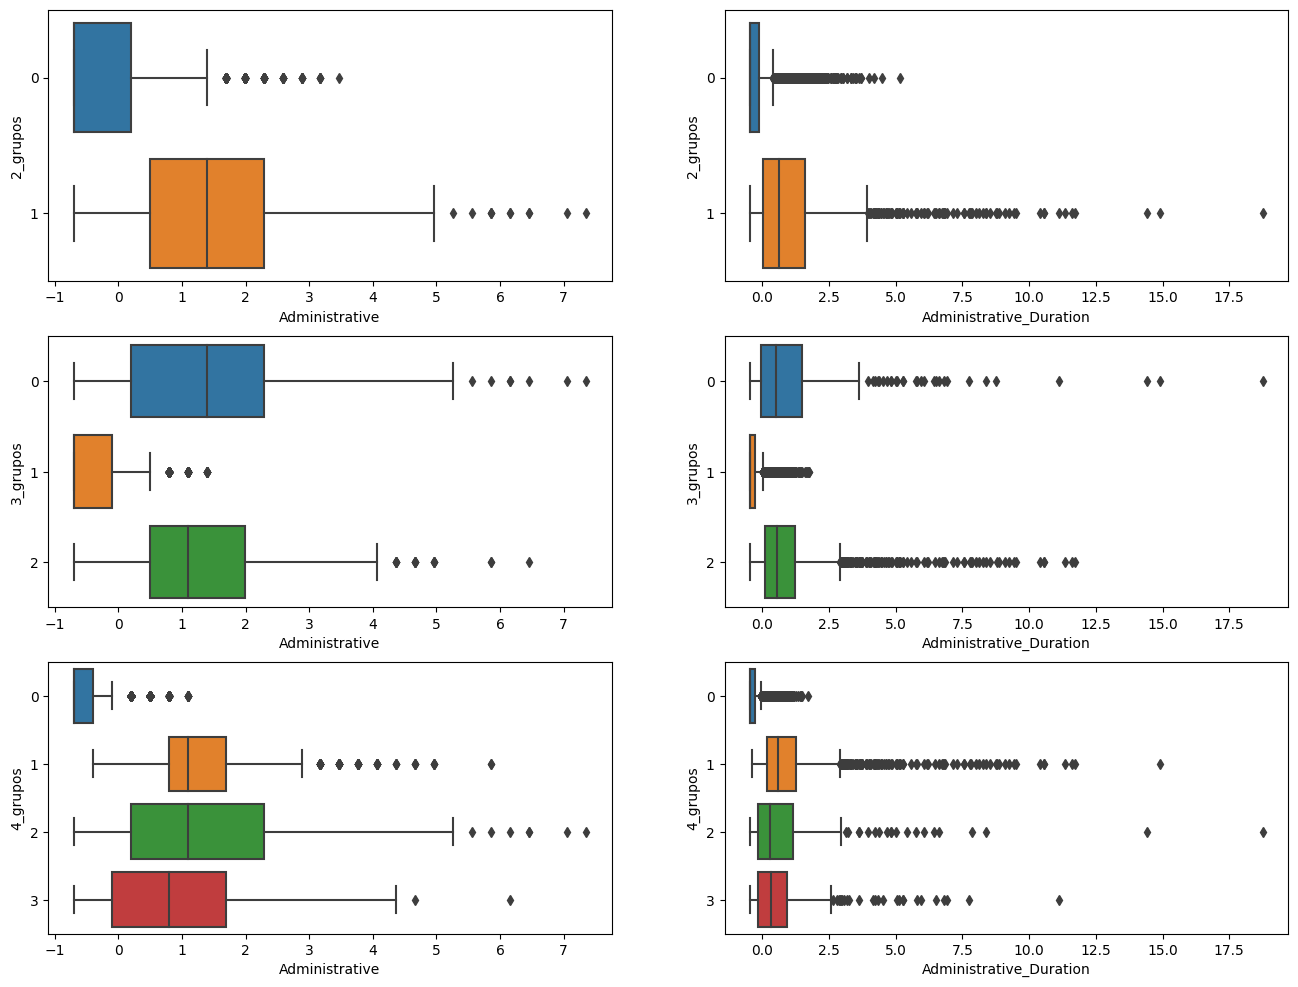

In [41]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(16, 12))
grupos = ["2_grupos", "3_grupos", "4_grupos"]
for i in range(2 * len(grupos)):
    sns.boxplot(data=model, ax=axes[i//2][i%2], y=grupos[i//2], x=variaveis[i%2])

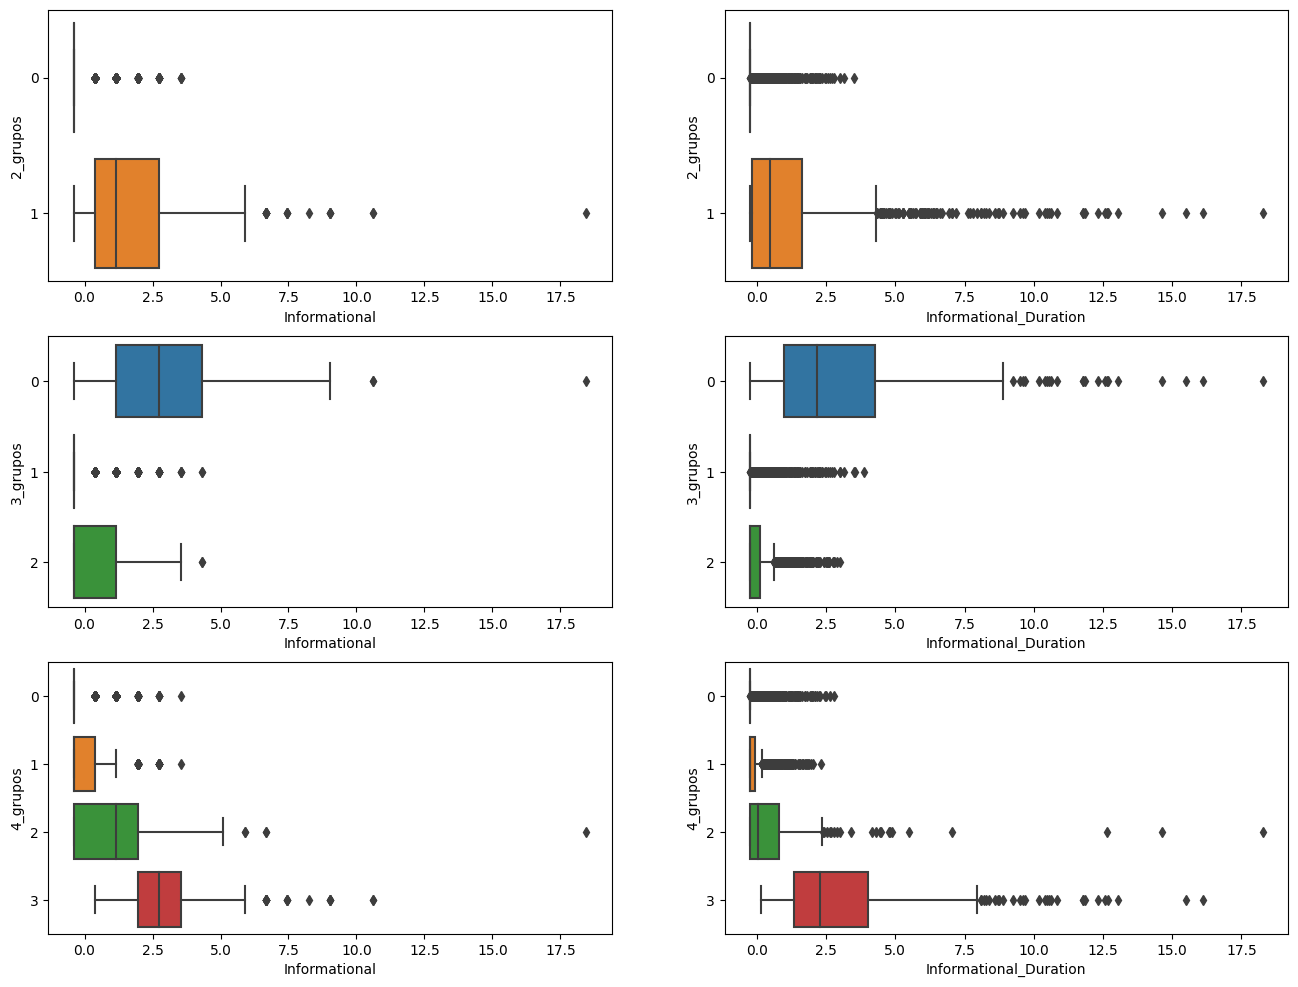

In [42]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(16, 12))
grupos = ["2_grupos", "3_grupos", "4_grupos"]
for i in range(2 * len(grupos)):
    sns.boxplot(data=model, ax=axes[i//2][i%2], y=grupos[i//2], x=variaveis[(i%2)+2])

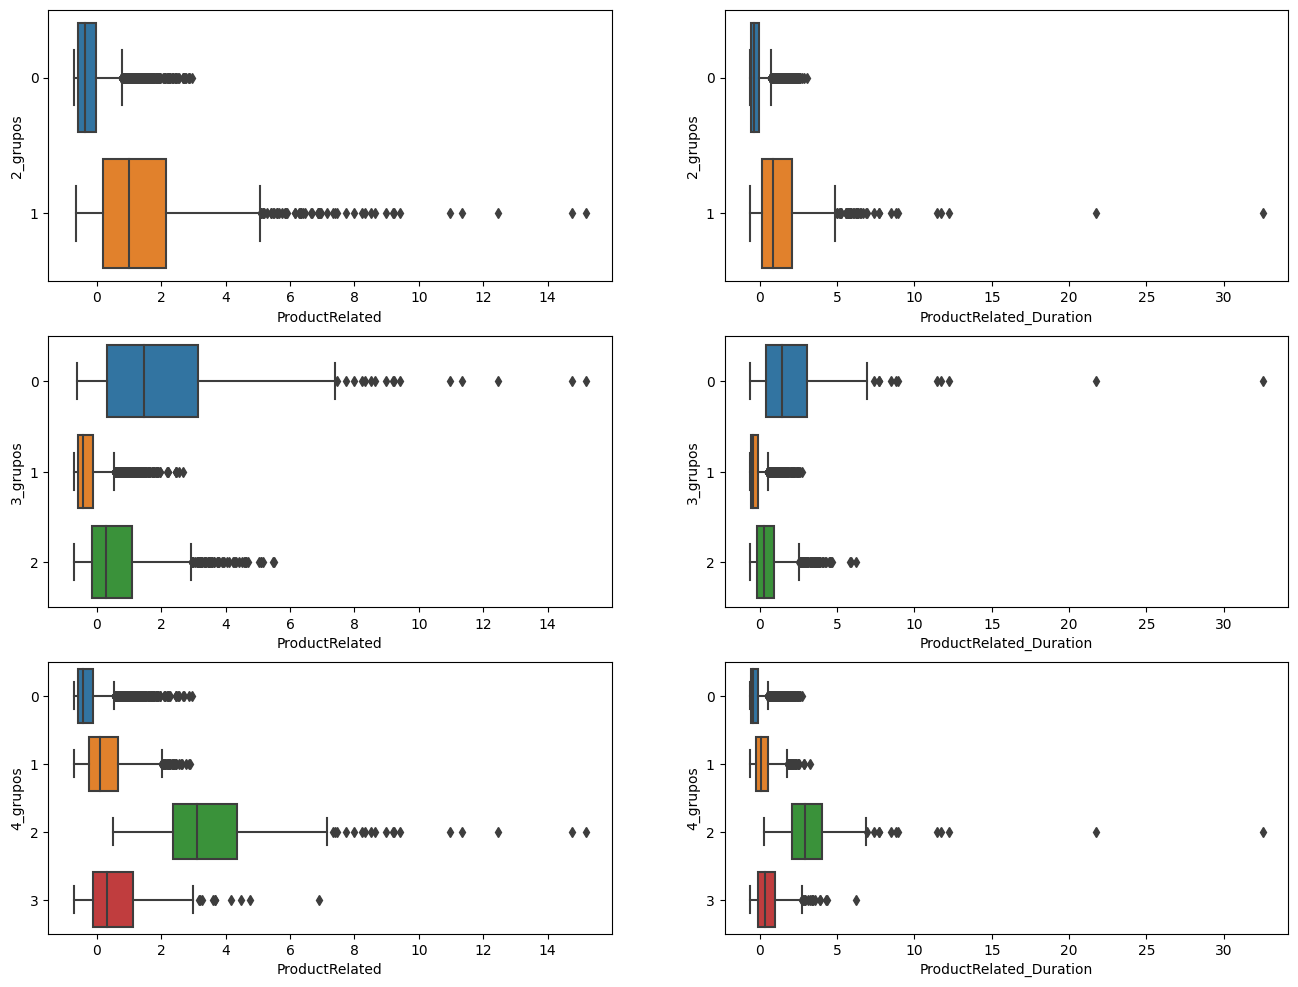

In [43]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(16, 12))
grupos = ["2_grupos", "3_grupos", "4_grupos"]
for i in range(2 * len(grupos)):
    sns.boxplot(data=model, ax=axes[i//2][i%2], y=grupos[i//2], x=variaveis[(i%2)+4])

## Avaliação de resultados

Avalie os grupos obtidos com relação às variáveis fora do escopo da análise (minimamente *bounce rate* e *revenue*). 
- Qual grupo possui clientes mais propensos à compra?

**Resposta:** Grupo 3. No entanto a classificação não parece explicar um comportamento diferenciado entre os grupos para a variável "bounce rate"

In [44]:
pd.crosstab(model['y1'], model['3_grupos'])

3_grupos,0,1,2
y1,,,
False,340,5653,1475
True,64,876,223


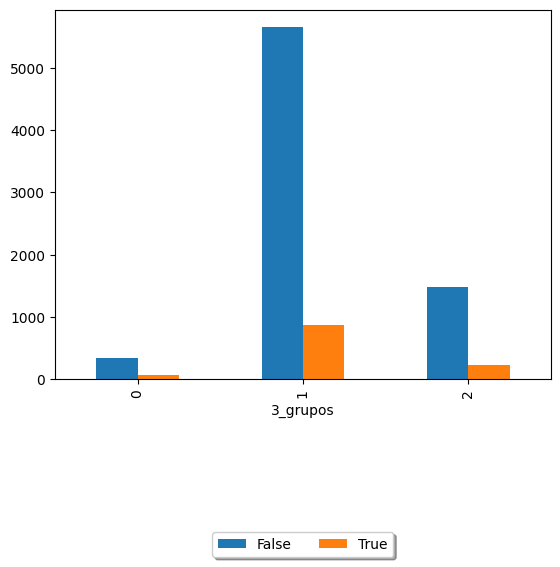

In [48]:
ax = model.groupby(['3_grupos', 'y1'])['y1'].count().unstack().plot.bar()

ax.legend(loc='lower center', bbox_to_anchor=(0.5, -.5),
          ncol=3, fancybox=True, shadow=True);

<AxesSubplot: xlabel='y2', ylabel='3_grupos'>

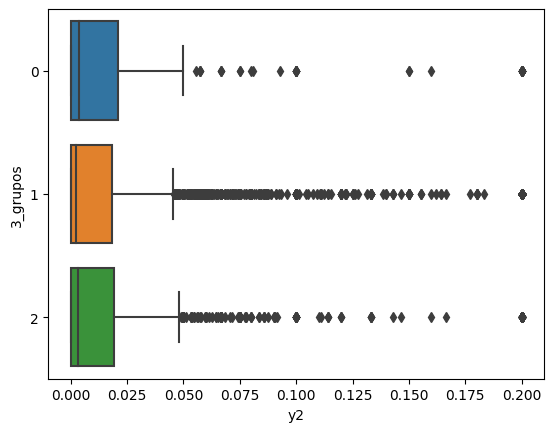

In [46]:
sns.boxplot(data=model, y="3_grupos", x="y2")